# Getting Started with OPERA DIST-ALERT-HLS Products

## Streaming and visualizing Cloud-Optimized GeoTIFF (COG) OPERA DIST-ALERT-HLS products using CMR's SpatioTemporal Asset Catalog (CMR-STAC)

### This tutorial demonstrates how to query and work with the OPERA DIST-ALERT-HLS Provisional Data products from the cloud ([OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0](https://lpdaac.usgs.gov/products/opera_l3_dist-alert-hls_provisional_v0v000/)).
---

### Data Used in the Example

* **30 meter (m) global OPERA Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 provisional product (Version 0) - [OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0](https://lpdaac.usgs.gov/products/opera_l3_dist-alert-hls_provisional_v0v000/)**<br>
    - The Observational Products for End-Users from Remote Sensing Analysis (OPERA) Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 (HLS) provisional data product Version 0 maps vegetation disturbance alerts from data collected by Landsat 8 and Landsat 9 Operational Land Imager (OLI) and Sentinel-2A and Sentinel-2B Multi-Spectral Instrument (MSI). Vegetation disturbance alert is detected at 30 meter (m) spatial resolution when there is an indicated decrease in vegetation cover within an HLS pixel. The product also provides auxiliary generic disturbance information as determined from the variations of the reflectance through the HLS scenes to provide information about more general disturbance trends. HLS data represent the highest temporal frequency data available at medium spatial resolution. The combined observations will provide greater sensitivity to land changes, whether of large magnitude/short duration, or small magnitude/long duration.
    - The OPERA_L3_DIST-ALERT-HLS (or DIST-ALERT) data product is provided in Cloud Optimized GeoTIFF (COG) format, and each layer is distributed as a separate file. There are 19 layers contained within in the DIST-ALERT product: vegetation disturbance status, current vegetation cover indicator, current vegetation anomaly value, historical vegetation cover indicator, max vegetation anomaly value, vegetation disturbance confidence layer, date of initial vegetation disturbance, number of detected vegetation loss anomalies, and vegetation disturbance duration. See the Product Specification for a more detailed description of the individual layers provided in the DIST-ALERT product.
* **Science Dataset (SDS) Layers**
    - VEG_ANOM_MAX (Maximum Vegetation Anomaly Layer)
    - VEG_DIST_DATE (Vegetation Disturbance Date Layer)
    - VEG_DIST_STATUS (Vegetation Disturbance Status Layer)

Please refer to the [OPERA DIST Product Specification Document](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_DIST_HLS.pdf) for details about the DIST-ALERT-HLS product.
<br><br>

---
<br> 

## Topics Covered
> 1. Getting Started
> 2. CMR-STAC API: Search for data based on spatial query
> 3. Load and visualize DIST-ALERT-HLS COGs from the Cloud
> 4. Demonstrate time slider visualization tool
<br>
---
<br>

## Before Starting this Tutorial
A [NASA Earthdata Login](https://urs.earthdata.nasa.gov) account is required to download the data used in this tutorial. You can create an account using the link provided.
<br><br>
---


## 1. Getting Started <br>
### 1.1 Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
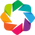

In [8]:
# Notebook dependencies
import os
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

from pystac_client import Client  
from pystac_client import ItemSearch
from pystac.item import Item
from typing import Dict, Any
import json

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
from tqdm import tqdm
import math

from shapely.geometry import box
from shapely.geometry import shape
from shapely.ops import transform

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from skimage import io

from osgeo import gdal
import rasterio as rio
import rioxarray
from rioxarray.merge import merge_arrays

import folium
from folium import plugins

import ipyleaflet

import pyproj
from pyproj import Proj

import xarray as xr
import panel as pn
import panel.widgets as pnw
import geoviews as gv
import hvplot.xarray
import holoviews as hv

from bokeh.models import FixedTicker
hv.extension('bokeh')
gv.extension('bokeh', 'matplotlib')

import warnings
warnings.filterwarnings('ignore')

from Stream_and_Viz_DIST_Functions import intersection_percent, stack_bands, time_and_area_cube, compute_area, standard_date, colorize, mask_rasters, getbasemaps, transform_data_for_folium, handle_draw


### 1.2 Set Up Working Environment

In [3]:
inDir = os.getcwd()
os.chdir(inDir)

### 1.3 Generate Authentication Token

The cell below generates an authentication token and asks for your Earthdata username/password the first time if netrc does not exist in your home directory.

In [4]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

# Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [5]:
# GDAL configurations used to successfully access PODAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')

## 2. CMR_STAC API: Search for Data Based on Spatial Query and Cloud Cover

### 2.1 Initialize User-Defined Parameters

The user should only specify parameters in the cell directly below, indicating:
* **Area of Interest**: coordinates entered as a shapely.geometry box object
* **Start and Stop Dates of Interest**: default stop date is set as present day
* **Overlap Threshold**: minimum required % spatial overlap between the AOI and DIST tiles obtained through search for DIST tile to be deemed "acceptable"
* **Cloud Cover Threshold**: maximum % cloud cover allowed for a DIST tile to be deemed "acceptable"


In [18]:
### Add functionality for drawing an AOI
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.WorldImagery,
    center=(37, -100),
    zoom=3.5,
    crs=ipyleaflet.projections.EPSG3857
    )

dc = ipyleaflet.DrawControl(
    polygon={},
    rectangle={"shapeOptions": {"color": "blue"}},
    circlemarker={},
    polyline={}
)

print('Select an Area of Interest using the tools on the left side of the map.')
dc.on_draw(handle_draw)
m.add_control(dc)
display(m)

Select an Area of Interest using the tools on the left side of the map.


Map(center=[37, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [28]:
# User-Defined Parameters
#aoi = box(67.991, 27.051, 68.002, 27.089)
ll = dc.last_draw['geometry']['coordinates'][0][0]
ur = dc.last_draw['geometry']['coordinates'][0][2]
aoi = box(ll[0], ll[1], ur[0], ur[1])
start_date = datetime(2022, 1, 1)                                   
#stop_date = f"{datetime.today().strftime('%Y-%m-%d')} 23:59:59"         
stop_date = datetime(2023,6, 1)
overlap_threshold = 50                                                  
cloud_cover_threshold = 20                                           

print(f"Search between {start_date} and {stop_date}")
print(f"With AOI: {aoi.__geo_interface__}")

Search between 2022-01-01 00:00:00 and 2023-06-01 00:00:00
With AOI: {'type': 'Polygon', 'coordinates': (((-121.948242, 40.488737), (-121.948242, 41.079351), (-123.00293, 41.079351), (-123.00293, 40.488737), (-121.948242, 40.488737)),)}


In [29]:
# Search data through CMR-STAC API
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [start_date, stop_date],
                 "limit": 50,
                 "max_items": 1000
                }
search_dist = api.search(**search_params)

### 2.2 Query DIST-ALERT-HLS tiles based on cloud cover and spatial overlap with respect to defined AOI

In [30]:
# Filter datasets based on spatial overlap and cloud cover
intersects_geometry = aoi.__geo_interface__

#Check percent overlap values
print("Percent overlap before filtering: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in search_dist.items()])

# Check percent cloud cover values
print("\nPercent cloud cover before filtering: ")
print([f"{i.properties['eo:cloud_cover']}" for i in search_dist.items()])

Percent overlap before filtering: 
['19.56', '87.74', '9.85', '26.88', '3.07', '24.57', '9.46', '87.74', '9.85', '26.88', '3.07', '57.26', '19.54', '87.74', '9.85', '26.88', '3.07', '87.74', '9.85', '26.80', '3.07', '56.50', '19.30', '0.19', '87.74', '26.88', '57.73', '19.67', '0.24', '0.31', '9.85', '87.74', '26.88', '3.07', '57.47', '19.60', '87.74', '9.85', '26.88', '3.07', '0.30', '0.23', '57.24', '19.53', '87.74', '9.85', '26.88', '3.07', '24.42', '9.40', '57.48', '19.61', '0.44', '0.53', '87.74', '26.88', '3.07', '9.85', '87.74', '3.07', '26.88', '24.08', '9.30', '57.53', '19.62', '87.74', '3.07', '5.86', '14.81', '0.65', '0.76', '9.85', '87.74', '26.88', '3.07', '22.83', '8.92', '87.74', '9.85', '26.88', '3.07', '57.01', '19.46', '26.88', '3.07', '0.29', '0.22', '9.85', '87.74', '3.07', '26.88', '58.04', '19.76', '25.20', '9.65', '87.74', '9.85', '26.88', '3.07', '57.87', '19.72', '0.11', '0.07', '87.74', '9.85', '26.88', '3.07', '87.74', '9.85', '26.88', '3.07', '25.91', '9.86'

The percent spatial overlap values above vary from only 40% to  a perfect 100%. The following filtering process will only keep tiles with spatial overlap greater than 50%. Similarly, cloud cover values ranging from 0 to 100 can be observed above. The filtering process will also only keep tiles with less than 20% cloud cover.

In [31]:
# Apply spatial overlap and cloud cover threshold
dist_filtered = (
    i for i in search_dist.items() if (intersection_percent(i, intersects_geometry) 
                                       > overlap_threshold and 
                                       i.properties['eo:cloud_cover'] < cloud_cover_threshold)
)

Inspecting one DIST tile from the filtered query, its metadata can be easily accessed as seen below.

In [32]:
dist_data = list(dist_filtered)

dist_data[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'OPERA_L3_DIST-ALERT-HLS_T10TEL_20230315T185139Z_20230317T140426Z_S2B_30_v0',
 'properties': {'eo:cloud_cover': 14,
  'datetime': '2023-03-15T19:03:15.484000Z',
  'start_datetime': '2023-03-15T19:03:15.484Z',
  'end_datetime': '2023-03-15T19:03:15.484Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-121.7033626, 40.5554731],
    [-121.6837996, 41.5443115],
    [-122.4153355, 41.5503583],
    [-122.7195688, 40.5624096],
    [-121.7033626, 40.5554731]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0.v0/items/OPERA_L3_DIST-ALERT-HLS_T10TEL_20230315T185139Z_20230317T140426Z_S2B_30_v0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_PROVISIONAL_V0.v0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT

In [33]:
# Print search information
# Total granules
print(f"Total granules after search filter: {len(dist_data)}")

# Check percent overlap values
print("Percent-overlap: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in dist_data])

# Check cloud cover values
print("Cloud-cover: ")
print([f"{x.properties['eo:cloud_cover']}" for x in dist_data])

Total granules after search filter: 16
Percent-overlap: 
['57.73', '87.74', '87.74', '57.01', '87.74', '57.87', '87.74', '87.74', '57.79', '57.28', '87.74', '57.61', '87.74', '57.85', '57.85', '58.15']
Cloud-cover: 
['14', '16', '16', '1', '5', '1', '1', '0', '7', '12', '0', '1', '0', '0', '2', '18']


Observing percent spatial overlap and cloud cover values after filtering, it is evident that only DIST tiles covering most of the AOI with minimal cloud cover are now available to the user.<br><br>In the figure produced below, the overlap between the boundary of the AOI and varying DIST tile boundaries is shown over a basemap.

In [34]:
# Visualize the DIST tile boundary and the user-defined box
geom_df = []
for d,_ in enumerate(dist_data):
    geom_df.append(shape(dist_data[d].geometry))

geom_granules = gpd.GeoDataFrame({'geometry':geom_df})
granules_poly = gv.Polygons(geom_granules).opts(line_color='blue', color=None)

# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=1000, height=1000)

# Get the user-specified aoi
geom_aoi = shape(intersects_geometry)
aoi_poly = gv.Polygons(geom_aoi).opts(line_color='yellow', color=None)

# Plot using geoviews wrapper
granules_poly*base*aoi_poly

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

DIST tiles adhering to the spatial overlap and cloud cover thresholds can be sorted in the table below, listing each tile's spatial coverage, cloud cover, and bandlink.

In [35]:
# Create table of search results
dist_data_df = []
for item in dist_data:
    item.to_dict()
    fn = item.id.split('_')
    ID = fn[3]
    sensor = fn[6]
    dat = item.datetime.strftime('%Y-%m-%d')
    spatial_coverage = intersection_percent(item, intersects_geometry)
    cloud_cover = item.properties['eo:cloud_cover']
    geom = item.geometry
    bbox = item.bbox

    # Take all the band href information 
    band_links = [item.assets[links].href for links in item.assets.keys()]
    dist_data_df.append([ID,sensor,dat,geom,bbox,spatial_coverage,cloud_cover,band_links])

dist_data_df = pd.DataFrame(dist_data_df, columns = ['TileID', 'Sensor', 'Date', 'Coords', 'bbox','SpatialCoverage','CloudCover','BandLinks'])
dist_data_df

,TileID,Sensor,Date,Coords,bbox,SpatialCoverage,CloudCover,BandLinks
0,T10TEL,S2B,2023-03-15,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-122.719569, 40.555473, -121.6838, 41.550358]",57.731213,14,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
1,T10TEL,L9,2023-03-26,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-123.00024, 40.555473, -121.6838, 41.551845]",87.743594,16,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
2,T10TEL,S2A,2023-04-12,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-123.00024, 40.555473, -121.6838, 41.551845]",87.743594,16,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
3,T10TEL,S2B,2023-04-14,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-122.710709, 40.555473, -121.6838, 41.550318]",57.012871,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
4,T10TEL,S2A,2023-04-22,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-123.00024, 40.555473, -121.6838, 41.551845]",87.743594,5,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
5,T10TEL,S2B,2023-04-24,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-122.720986, 40.555473, -121.6838, 41.550369]",57.865549,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
6,T10TEL,L9,2023-04-27,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-123.00024, 40.555473, -121.6838, 41.551845]",87.743594,1,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
7,T10TEL,S2B,2023-04-27,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-123.00024, 40.555473, -121.6838, 41.551845]",87.743594,0,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
8,T10TEL,S2A,2023-04-29,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-122.720277, 40.555473, -121.6838, 41.550362]",57.790556,7,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
9,T10TEL,S2A,2023-05-09,"{'type': 'Polygon', 'coordinates': [[[-121.703...","[-122.713899, 40.555473, -121.6838, 41.550334]",57.279920,12,[https://data.lpdaac.earthdatacloud.nasa.gov/l...


## 3. Load and Visualize DIST-ALERT-HLS COGs from the Cloud

If one tile is extracted from the filtered collection and its layers are examined, all 19 product layers are produced.

In [36]:
# Instead of reading in band links, need to project to folium's projection and merge tiles

# Need to implement transform_data_for_folium function in .py file
T42RUR_VEG_ANOM_MAX, T42RUR_VEG_ANOM_MAX_cm = transform_data_for_folium(dist_data_df.iloc[0].BandLinks[4])
T42RVR_VEG_ANOM_MAX, T42RVR_VEG_ANOM_MAX_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[4])
merged_VEG_ANOM_MAX = merge_arrays([T42RUR_VEG_ANOM_MAX, T42RVR_VEG_ANOM_MAX])


T42RUR_VEG_DIST_DATE, T42RUR_VEG_DIST_DATE_cm = transform_data_for_folium(dist_data_df.iloc[0].BandLinks[6])
T42RVR_VEG_DIST_DATE, T42RVR_VEG_DIST_DATE_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[6])
merged_VEG_DIST_DATE = merge_arrays([T42RUR_VEG_DIST_DATE, T42RVR_VEG_DIST_DATE])

T42RUR_VEG_DIST_STATUS, T42RUR_VEG_DIST_STATUS_cm = transform_data_for_folium(dist_data_df.iloc[0].BandLinks[0])
T42RVR_VEG_DIST_STATUS, T42RVR_VEG_DIST_STATUS_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[0])
merged_VEG_DIST_STATUS = merge_arrays([T42RUR_VEG_DIST_STATUS, T42RVR_VEG_DIST_STATUS])

In [38]:
masked_VEG_ANOM_MAX, masked_VEG_DIST_DATE,masked_VEG_DIST_STATUS = mask_rasters(merged_VEG_ANOM_MAX, merged_VEG_DIST_DATE, merged_VEG_DIST_STATUS)

colorized_VEG_ANOM_MAX = colorize(masked_VEG_ANOM_MAX[0])
colorized_VEG_DIST_DATE = colorize(masked_VEG_DIST_DATE[0])
colorized_VEG_DIST_STATUS = colorize(masked_VEG_DIST_STATUS[0])


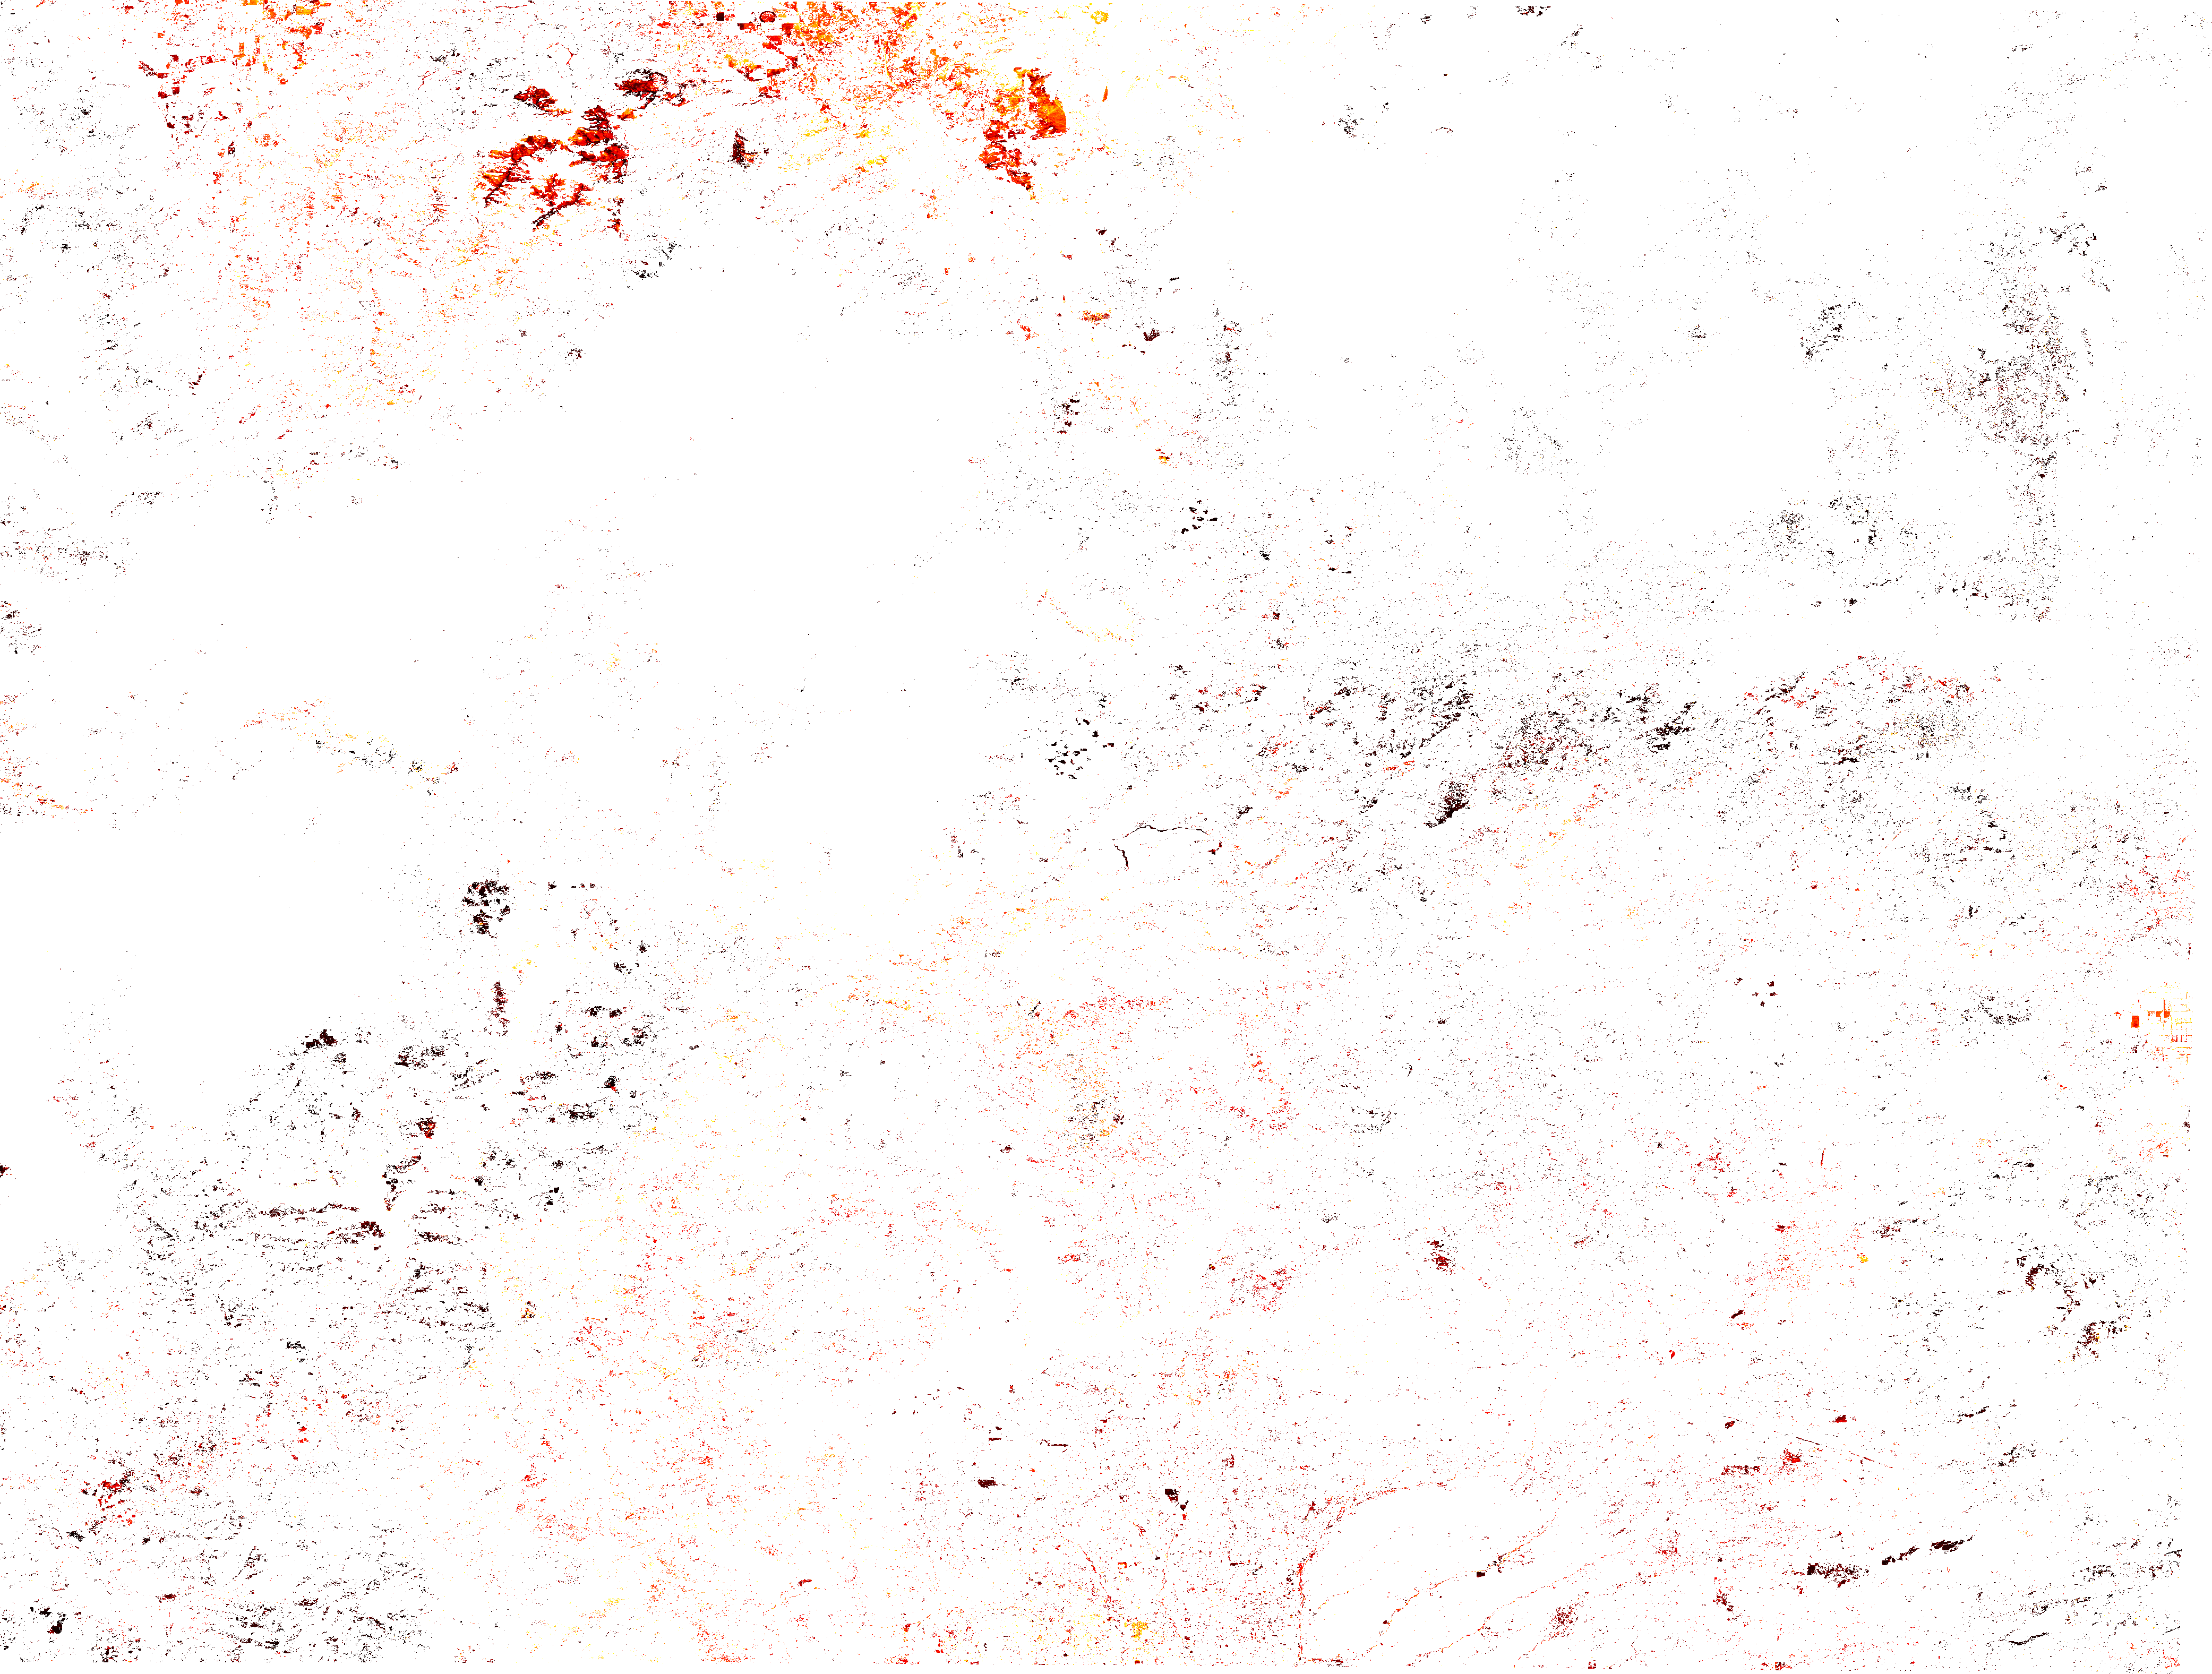
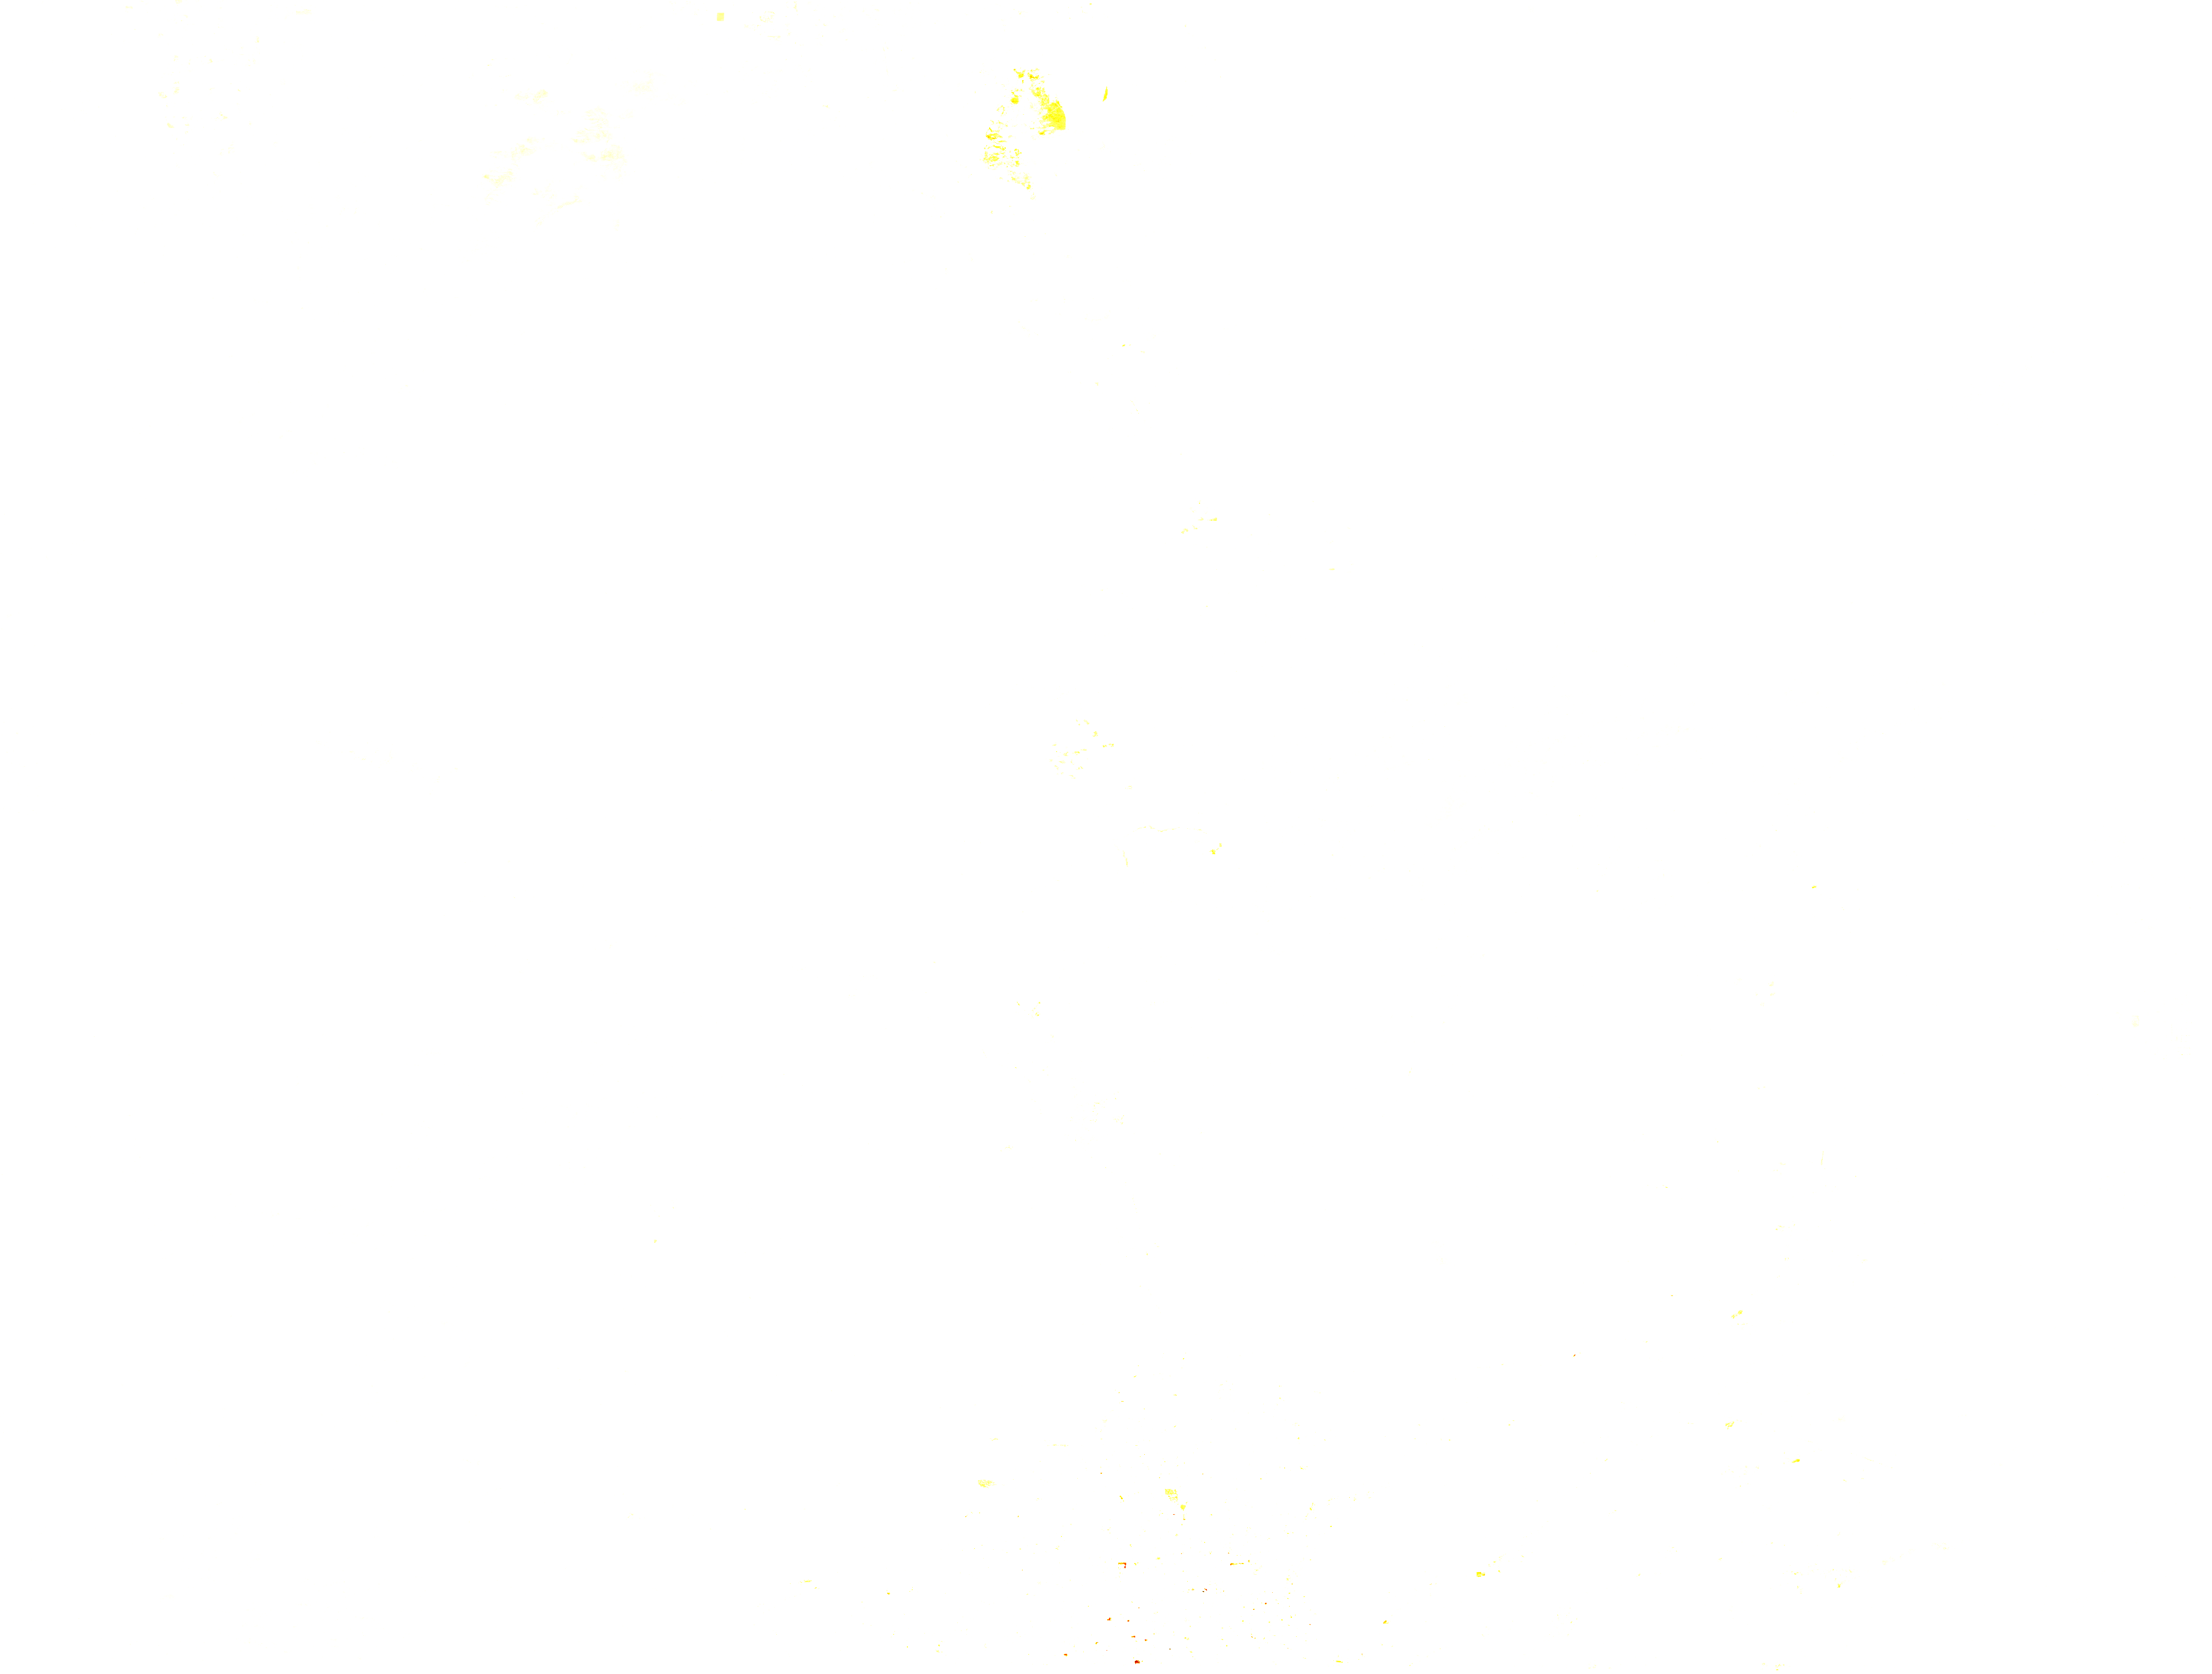
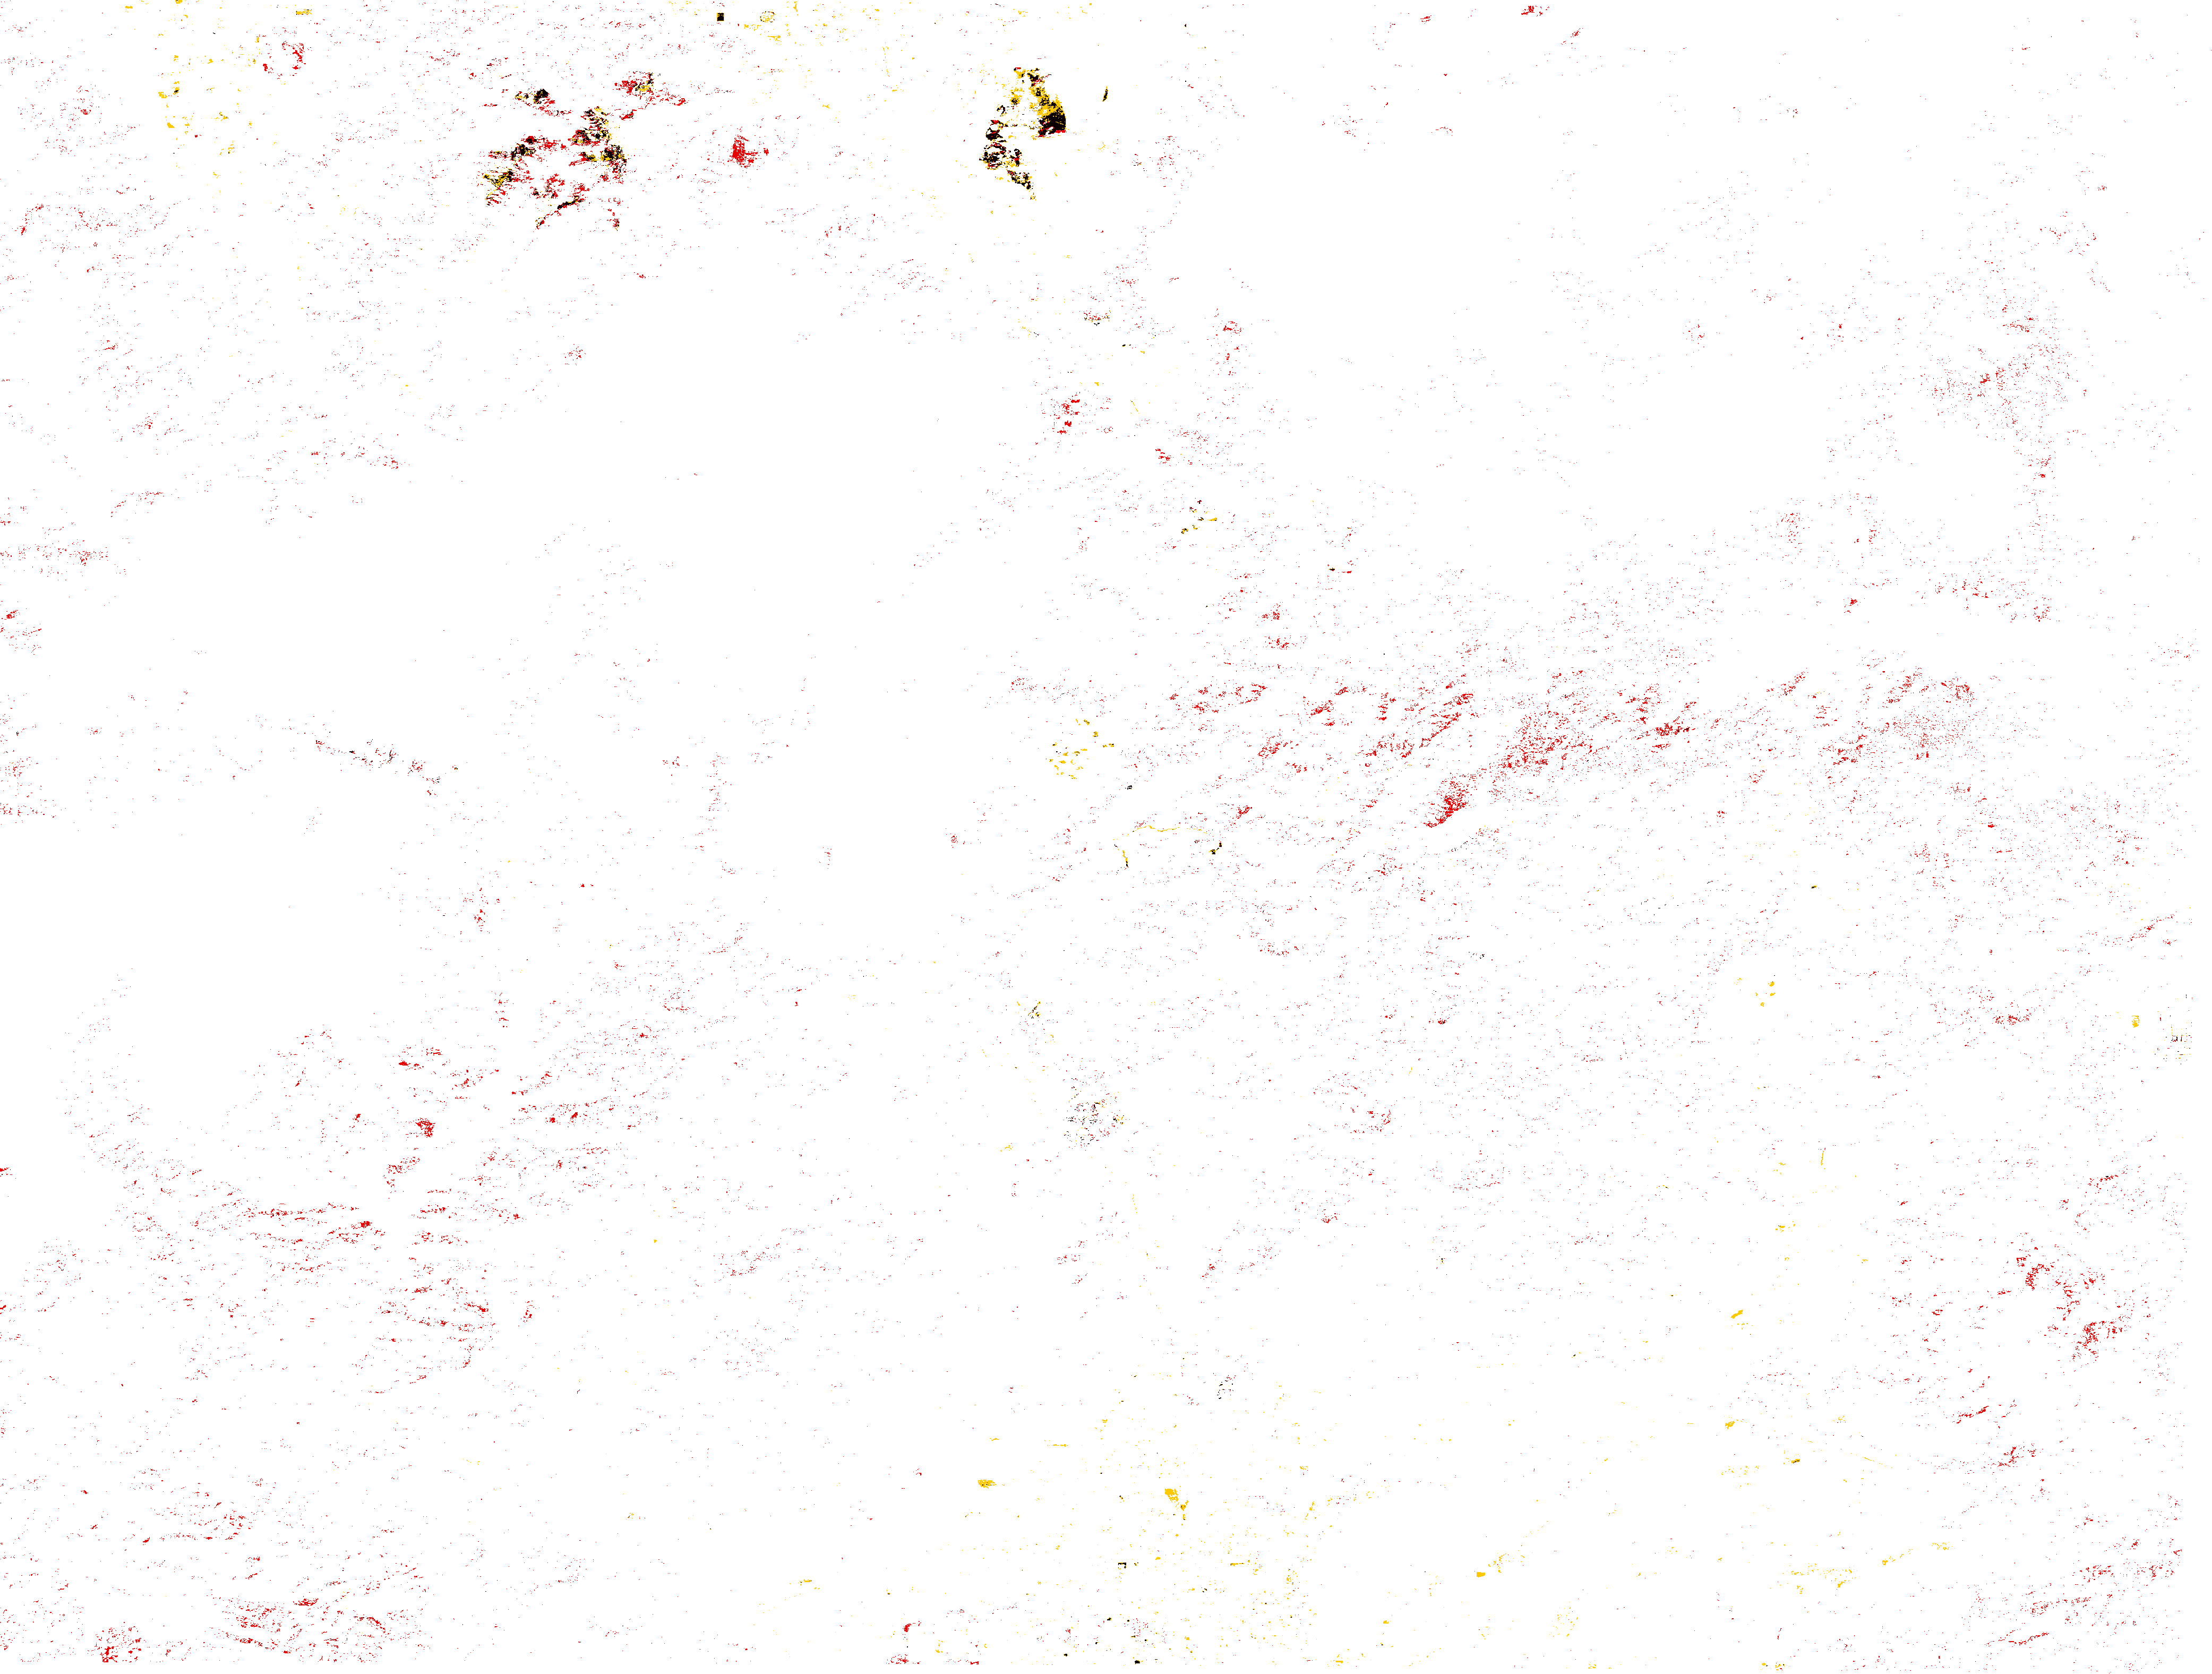

In [39]:
# Initialize Folium basemap
xmid =(merged_VEG_ANOM_MAX.x.values.min()+merged_VEG_ANOM_MAX.x.values.max())/2 ; ymid = (merged_VEG_ANOM_MAX.y.values.min()+merged_VEG_ANOM_MAX.y.values.max())/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='CartoDB positron', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_ANOM_MAX, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_ANOM_MAX.y.values.min(),merged_VEG_ANOM_MAX.x.values.min()],[merged_VEG_ANOM_MAX.y.values.max(),merged_VEG_ANOM_MAX.x.values.max()]],
                                        name='VEG_ANOM_MAX',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_DIST_DATE, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_DIST_DATE.y.values.min(),merged_VEG_DIST_DATE.x.values.min()],[merged_VEG_DIST_DATE.y.values.max(),merged_VEG_DIST_DATE.x.values.max()]],
                                        name='VEG_DIST_DATE',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_DIST_STATUS, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_DIST_STATUS.y.values.min(),merged_VEG_DIST_STATUS.x.values.min()],[merged_VEG_DIST_STATUS.y.values.max(),merged_VEG_DIST_STATUS.x.values.max()]],
                                        name='VEG_DIST_STATUS',
                                        show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=200, height=200)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m